<a href="https://colab.research.google.com/github/psingh-xyz/Practical_DL/blob/spring23/week05_interpretability/PriyankaSingh_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep models interpretability
This notebooks shows examples of approaches for interpretation of (pre-)trained model predictions.

In [ ]:
try:
    import skimage
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'scikit-image'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import skimage

In [ ]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install pynvml
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.6 MB/s eta 0:00:00
Selected cuda:0


In [ ]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [ ]:
class_labels[897]

'washer'

### Task I: manual explanation with smoothgrad (2 points)

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [ ]:
model = torchvision.models.resnet18(pretrained=True).train(False).to(device)

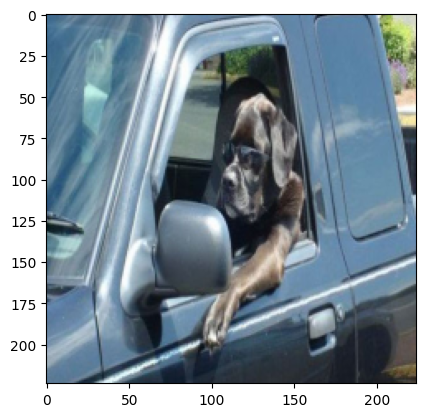

#1: p=0.096	brassiere (459)
#2: p=0.073	oxygen_mask (691)
#3: p=0.054	bloodhound (163)
#4: p=0.042	car_mirror (475)
#5: p=0.034	refrigerator (760)
#6: p=0.032	limousine (627)
#7: p=0.026	minibus (654)
#8: p=0.023	Saluki (176)
#9: p=0.023	minivan (656)
#10: p=0.021	iPod (605)


In [ ]:
!wget -q https://cdn2.adrianflux.co.uk/wp-fluxposure/uploads/2014/08/no-7.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

Now let's implement SmoothGrad itself.

In [ ]:
torch.as_tensor(image, device=device, dtype=torch.float32)[None].permute(0, 3, 1, 2).size(0)

1

<ipython-input-12-db7a257b11ea>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor_copy = torch.tensor(img_tensor_copy, requires_grad=True)


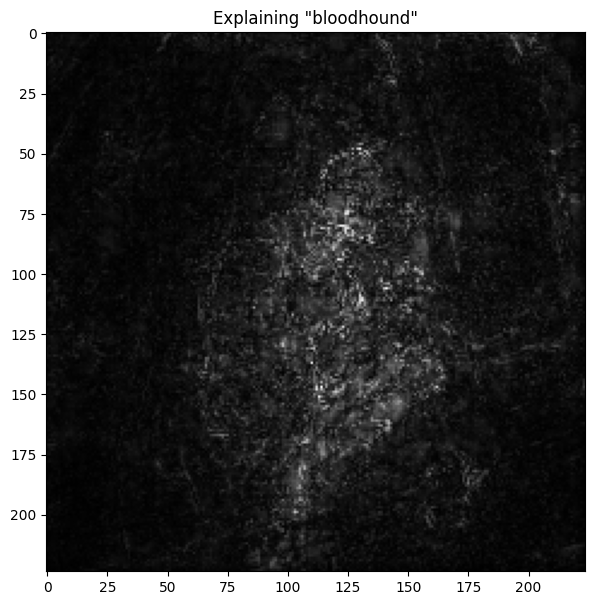

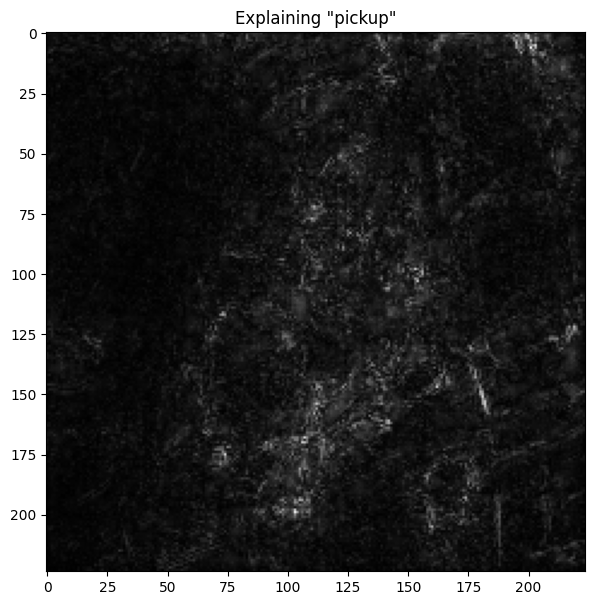

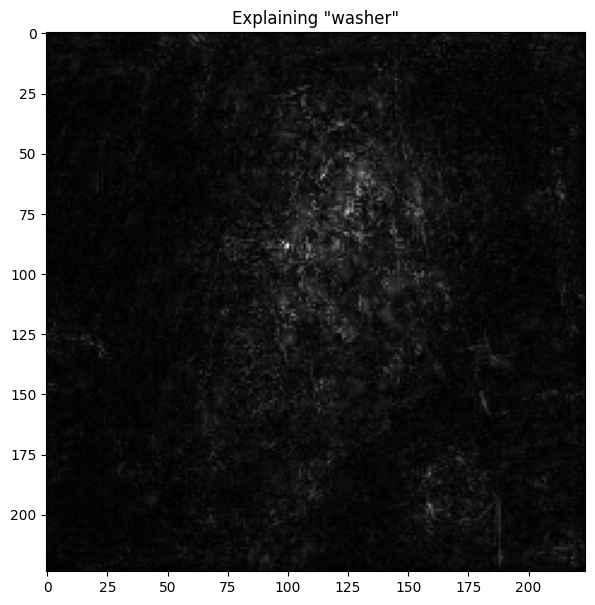

In [ ]:
def explain_smoothgrad(image: torch, class_ix, num_runs=32, sigma=0.1):
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)  # shape: [1, 3, h, w]

    # 1. create :num_runs: copies of an image
    # 2. apply independent random noise to each copy, use N(0, sigma) distribution
    # 3. compute gradients of logit for class_ix w.r.t. input pixels
    # 4. average these gradients across different images
    # 5. re-shape these gradients in the same shape as original image: (h, w, 3)

    average_gradients = torch.zeros(image_tensor.size()).to(device)
    for i in range(num_runs):
        img_tensor_copy = torch.Tensor(image_tensor)
        img_tensor_copy = img_tensor_copy + torch.normal(0, sigma, size=(1, 3, image_tensor.size(2), image_tensor.size(3))).to(device)
        img_tensor_copy = torch.tensor(img_tensor_copy, requires_grad=True)

        logits = model(img_tensor_copy)
        logits[0, class_ix].backward()
        average_gradients = average_gradients + img_tensor_copy.grad

    average_gradients = (average_gradients / num_runs).permute(2, 3, 1, 0).squeeze()

    assert tuple(average_gradients.shape) == image.shape
    return abs(average_gradients).norm(dim=-1).cpu().numpy()
    # return abs(average_gradients).cpu().numpy()

for class_ix in 163, 717, 897:  # <-- insert your classes here, use numbers in (brackets)
    plt.figure(figsize=[7, 7])
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

__Let's try it out!__ Peter Higgs nobel prize photo

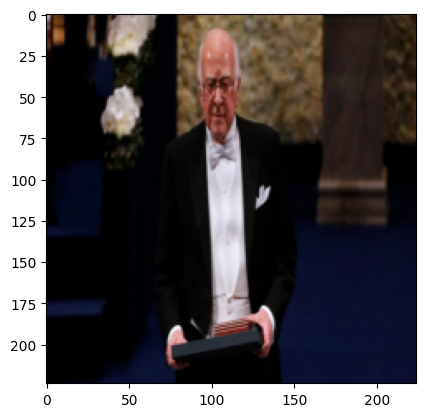

#1: p=0.196	suit (834)
#2: p=0.134	lab_coat (617)
#3: p=0.085	bow_tie (457)
#4: p=0.025	toilet_seat (861)
#5: p=0.023	abaya (399)
#6: p=0.018	hook (600)
#7: p=0.016	shower_curtain (794)
#8: p=0.015	plunger (731)
#9: p=0.015	balance_beam (416)
#10: p=0.015	torch (862)


<ipython-input-12-db7a257b11ea>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor_copy = torch.tensor(img_tensor_copy, requires_grad=True)


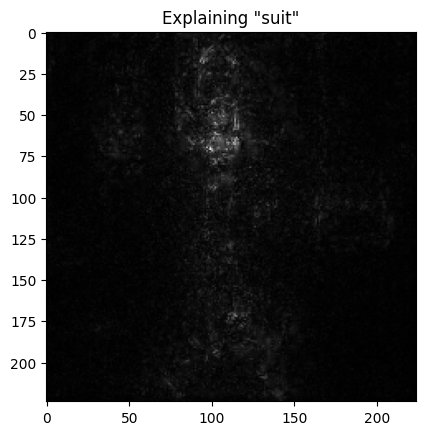

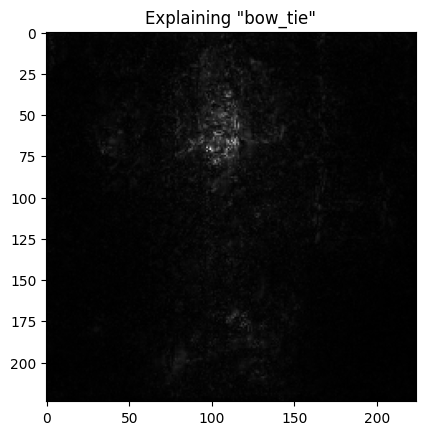

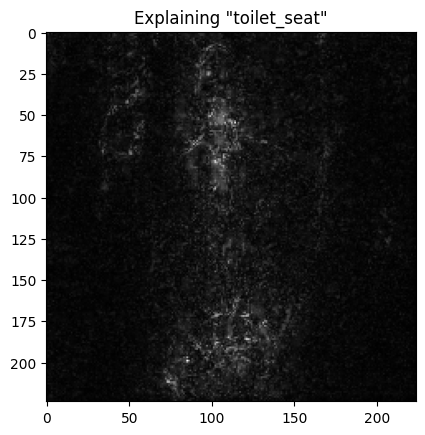

In [ ]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

for class_ix in 834, 457, 861:
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

### SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [ ]:
try:
    import shap
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'shap'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import shap

In [ ]:
shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [ ]:
background.size()

torch.Size([50, 3, 224, 224])

In [ ]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

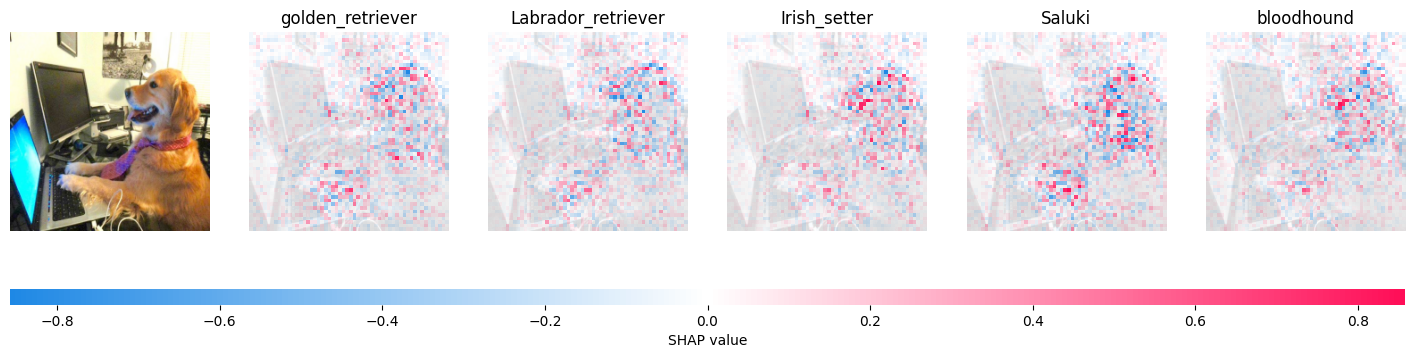

In [ ]:
# explain and visualize. If you're not using a powerful V100 GPU, this may take up to 20 minutes.
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

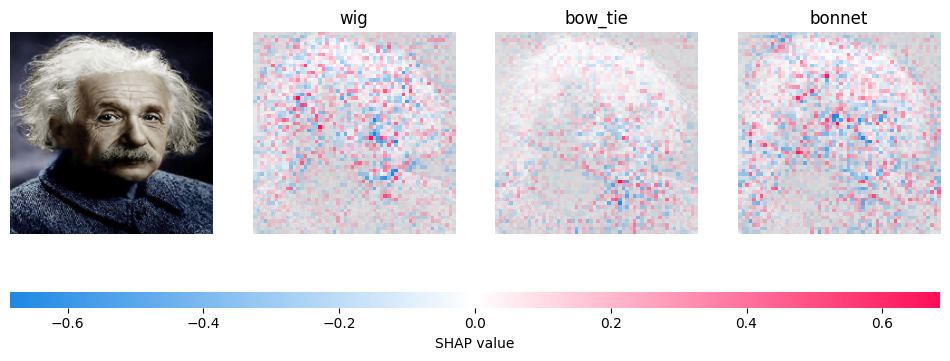

In [ ]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=3, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

###### Explaining classical machine learning models

Finally, let's see how SHAP explainers can be applied to more conventional machine learning models like gradient boosting.

Spoiler: exactly the same from a user's perspective. However, this time we're gonna use a different Shapley approximation implemented in TreeExplainer. For a full set of available explainers, take a look at their official [examples page](https://github.com/slundberg/shap/tree/master/notebooks).

**NB: the following cells requires JavaScript support and should work in Jupyter (not JupyterLab or cocalc)**.
In that case try running it on Google colab: https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb

In [ ]:
!pip install catboost
import shap
shap.initjs()
import catboost
from sklearn.datasets import fetch_openml
import pandas as pd


boston = fetch_openml(data_id=42165, as_frame=True)
X = boston.data
y = boston.target

# Exclude non-numeric columns
numeric_columns = X.select_dtypes(include=['number'])

ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(numeric_columns, y, verbose=False, plot=False)
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(numeric_columns)

# Visualize explanation of the first example
shap.force_plot(explainer.expected_value, shap_values[0, :], numeric_columns.iloc[0, :])


The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


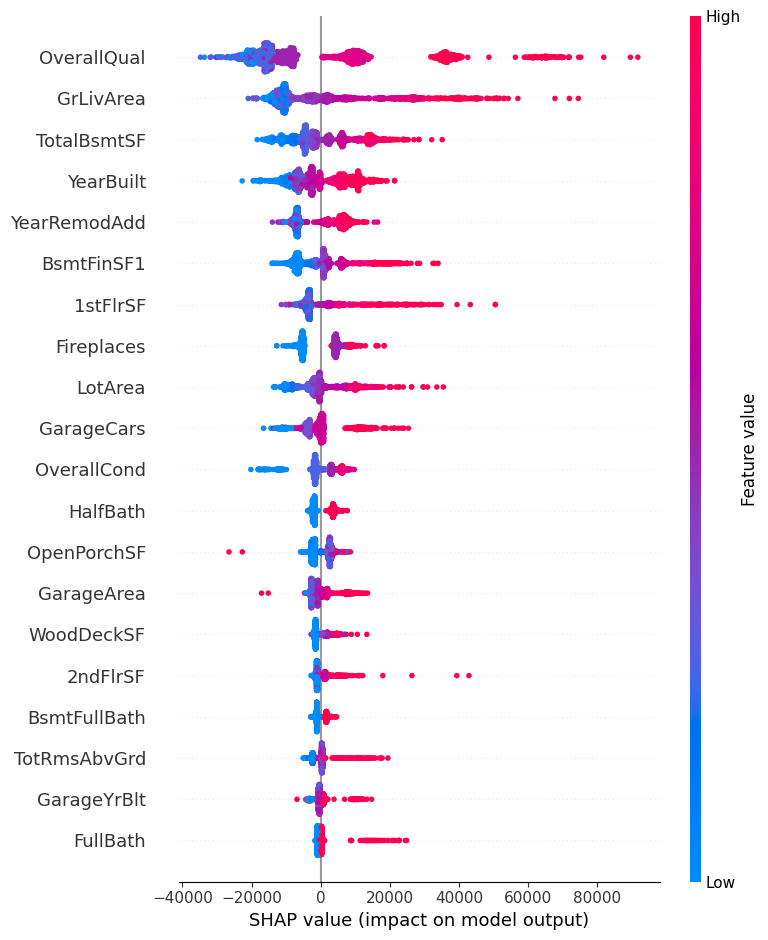

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values, X)


import shap
import catboost
import numpy as np
from sklearn.datasets import fetch_openml
import pandas as pd

# Load the Boston Housing dataset
boston = fetch_openml(data_id=42165, as_frame=True)
X = boston.data
y = boston.target

# Remove non-numeric columns or handle them appropriately
non_numeric_columns = X.select_dtypes(exclude='number')
X = X.select_dtypes(include='number')  # This will exclude non-numeric columns

# Create a CatBoost model
ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(X, y, verbose=False, plot=False)

# Create a SHAP explainer
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(X)

# Visualize a summary force plot
shap.initjs()
shap.summary_plot(shap_values, X)


### Task II: Explain Intermediate Layers of Resnet50 on ImageNet (5 points)

Sometimes, computing explanations w.r.t. pixels is more difficult (and less interpretable) than using intermediate layers that are closer to the "output" layer. The trick is to compute low-resolution explanations of output w.r.t. intermediate layer and then resizing them to fit the original image.

Each layer in deep CNN learns filters of increasing complexity. The first layers learn basic feature detection filters such as edges and corners. The middle layers learn filters that detect parts of objects — for faces, they might learn to respond to features like eyes and brows, and deeper layers capture entire objects.

**Your task** is to explain ResNet50 model outputs with respect to the convolution module from 2nd  and 4th layer of the pretrained Resnet50 network using the same GradientExplainer. *The task may require some googling or browsing the [docs](https://shap.readthedocs.io/en/latest) :)*

**Please use at least 10 images from across the internet (or from ImageNet) and compare the 2nd and 4th layer explanations on these images.**


In [ ]:
import json

In [ ]:
mean = [0.398, 0.345, 0.313]
std = [0.145, 0.156, 0.167]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<Figure size 2000x1000 with 0 Axes>

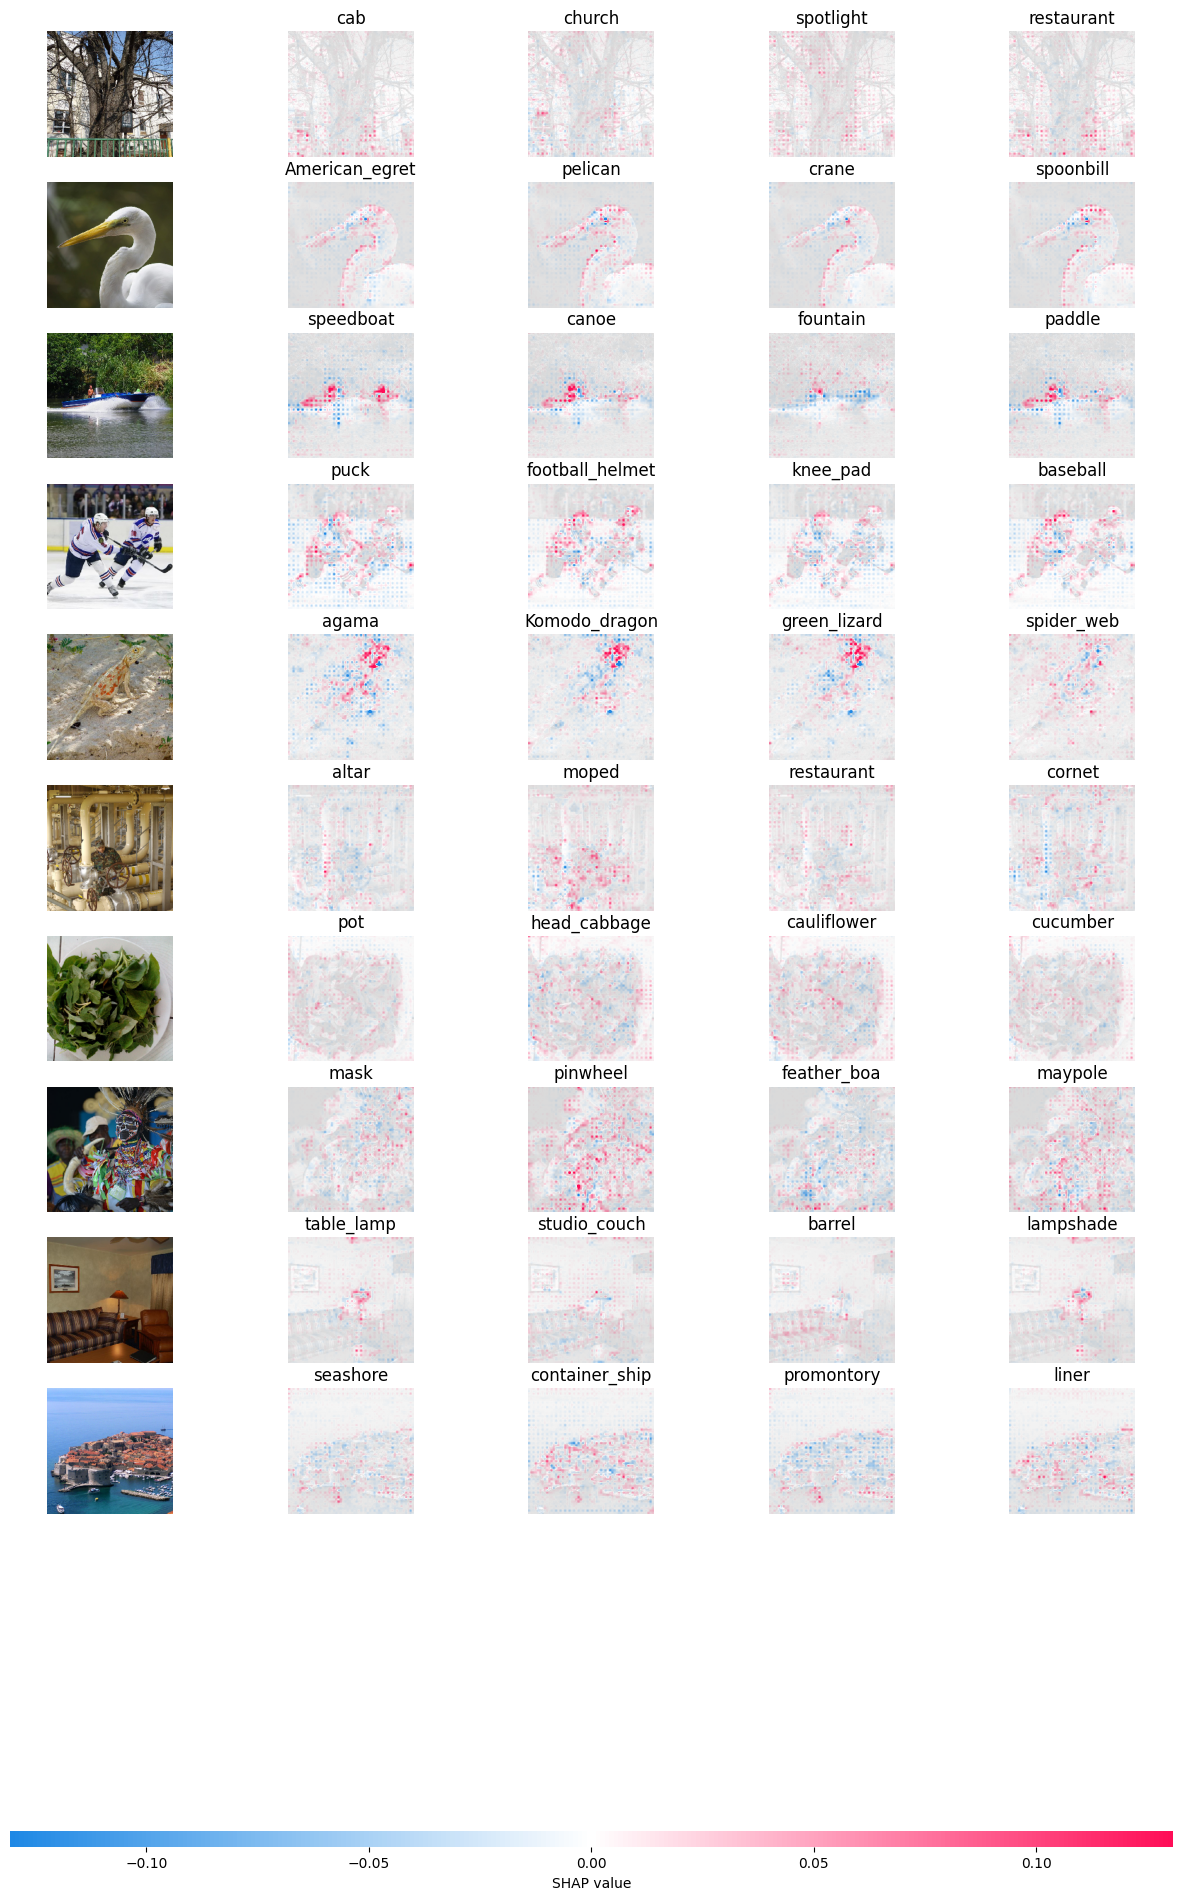

In [ ]:
model = torchvision.models.resnet18(pretrained=True).train(False).to(device)
X,y = shap.datasets.imagenet50()
X /= 255

explainer = X[0:10, :,:,:]

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
data = shap.datasets.cache(url)
with open(data) as d:
    class_names = json.load(d)

e = shap.GradientExplainer((model, model._modules['layer2']), torch.tensor(normalize(X)).to(device))
shap_values,indexes = e.shap_values(torch.tensor(normalize(explainer)).to(device), ranked_outputs=4, nsamples=250)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes.cpu().numpy())

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

plt.figure(figsize=(20,10))
shap.image_plot(shap_values, explainer, index_names)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


<Figure size 2000x1000 with 0 Axes>

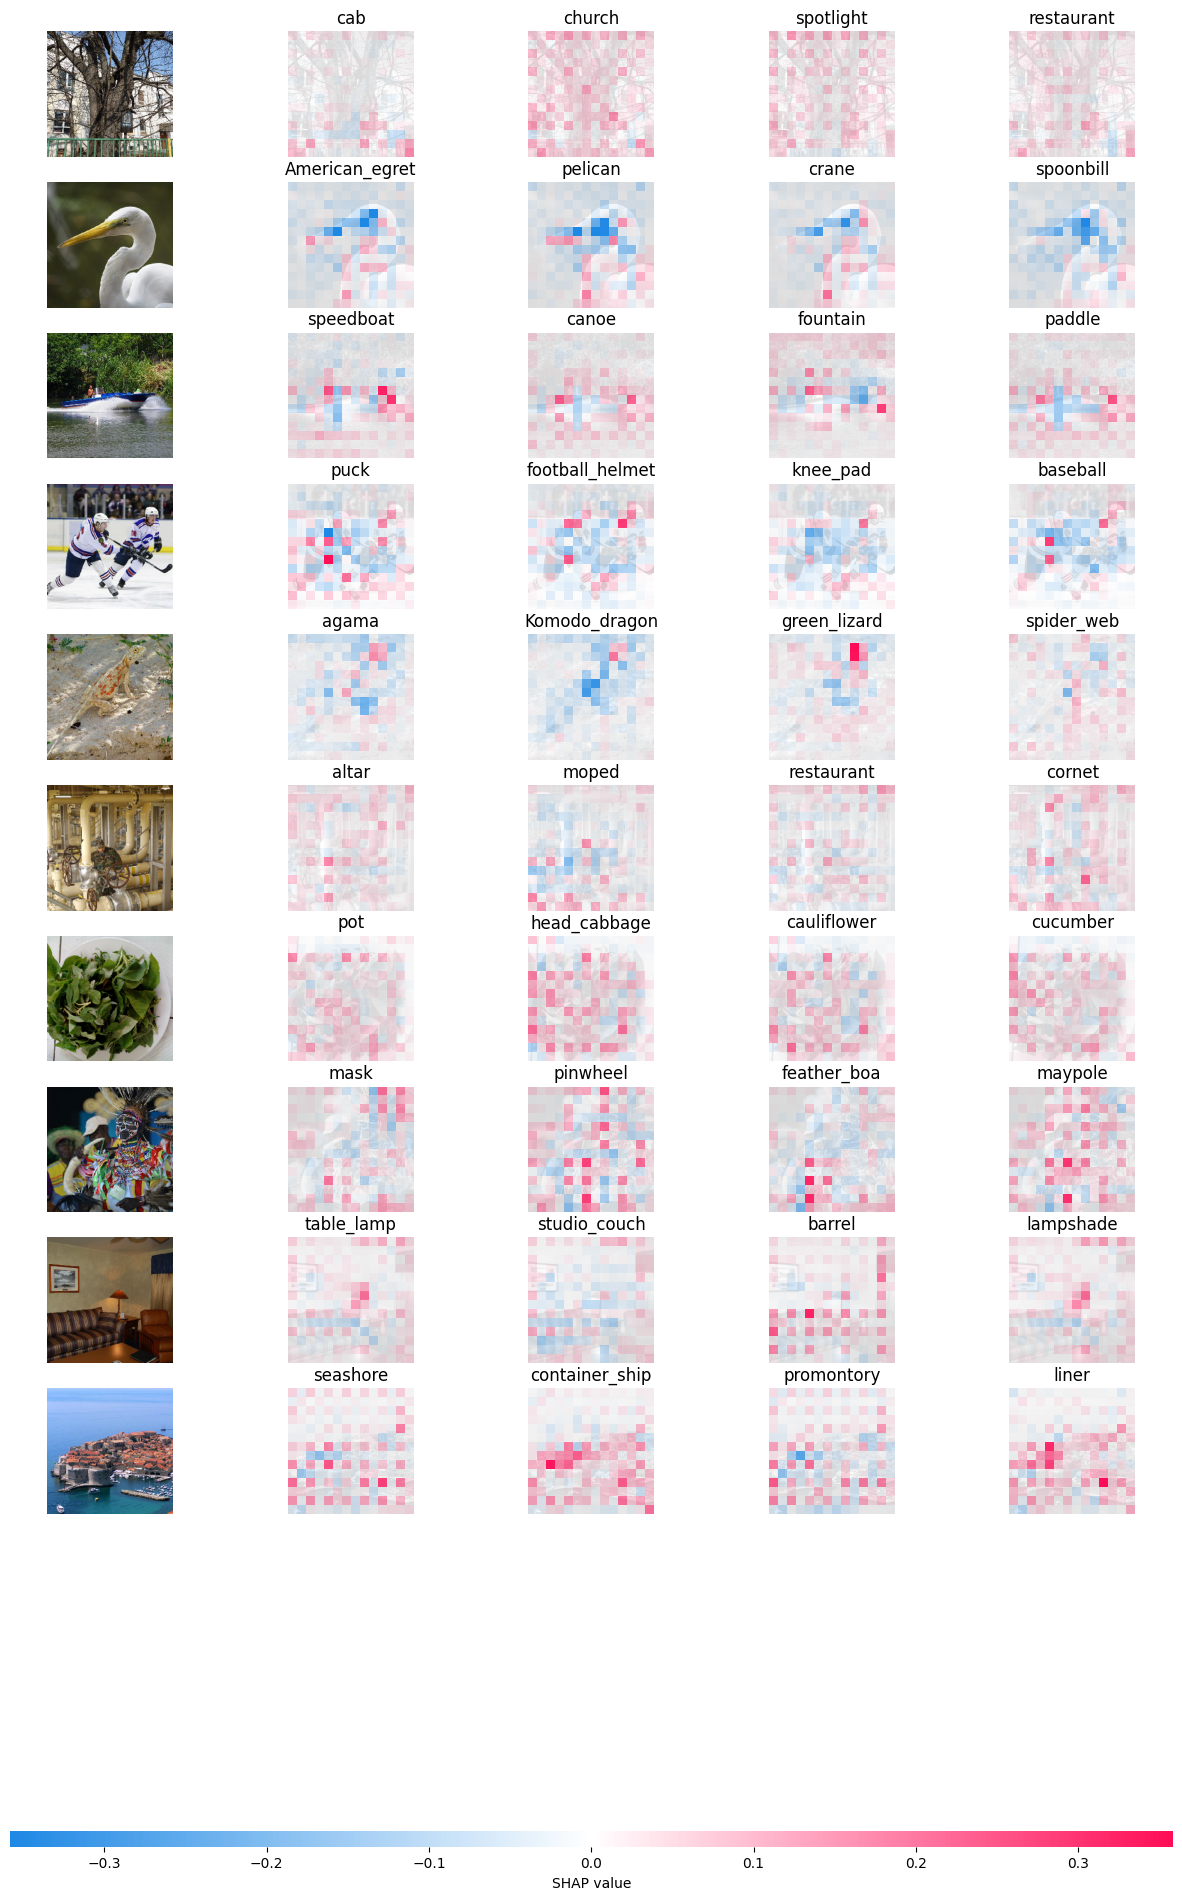

In [ ]:
model = torchvision.models.resnet18(pretrained=True).train(False).to(device)
X,y = shap.datasets.imagenet50()
X /= 255

explainer = X[0:10, :,:,:]

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
data = shap.datasets.cache(url)
with open(data) as d:
    class_names = json.load(d)

e = shap.GradientExplainer((model, model._modules['layer4']), torch.tensor(normalize(X)).to(device))
shap_values,indexes = e.shap_values(torch.tensor(normalize(explainer)).to(device), ranked_outputs=4, nsamples=250)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes.cpu().numpy())

# plot the explanations
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

plt.figure(figsize=(20,10))
shap.image_plot(shap_values, explainer, index_names)

## References

* SHAP explainer based on superpixels - [notebook](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html)
* SHAP reference notebook - [view on github](https://github.com/slundberg/shap/tree/master/notebooks)
* More various explainers in [ELI5](https://github.com/TeamHG-Memex/eli5)
* Same notebook on Google [Colab](https://colab.research.google.com/github/yandexdataschool/mlhep2020-assignments/blob/master/notebooks/interpretability/interpretability_demo.ipynb)